In [2]:
#Pipeline of freezing behavior analysis:
#This analysis use 4 parameters to define freezing response and other behaviors such as strikes and pc
#The 4 parameters are: Heart Rate, Head upward movemnet, Eye angle, and tail angle
#Freezing trials are defined as those with only bradycardia and no head, eye, or tail movement
#In this pipeline, we will create a excel file called bradyinfo to store the analyzed result and data
#Stepwise, we detect its bradycardia, strikes, pc, and swim
#We then plot the result of each param and store in seperate folder

#step by step Pipeline:
#1.Bradycardia Classification
    #1.1 Draw ROIs in Fiji circling the entire heart
    #1.2 create bradyinfo and get heart rate trace
    #1.3 classify whether each trial has bradycardia
#2.Strike Detection
    #2.1 Draw ROI above fish head that the head enters during strike
    #2.2 Run strike detection fish by fish and check the result
    #2.3 store strike detection result in bradyinfo
#3. PC Detection
    #3.1 Use Ztrack to track the eye and tail angles
    #3.2 Use eye angles of each fish to fit bimodal distribution and find threshold
    #3.3 Detect PC in each trials
    #3.4 Store PC result in Bradyinfo
#4. Tail Angle Detection
    #4.1 
#5. Plottings:
    #5.1 Averaged Heart Rate for each stimulus
    #5.2 Heart Rate Reduction of each condition
    #5.3 Individual Fish Pie Chart of response: Freeze, PC, Strikes, Escape, Other Swim, No Response
    #5.4 All fish Response Rate Pie Chart
    #5.5 Tail movement Comparision 

In [3]:
import tifffile
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import find_objects, gaussian_filter, label
import pandas as pd
import os
import cv2
from sklearn import linear_model
from sklearn.metrics import r2_score 
from skimage.filters import apply_hysteresis_threshold

from Brady_Ana_AIO_Functions import *
from Brady_Classifier_Functions import *

from scipy.signal import butter, filtfilt
import pickle
import json
import re
from datetime import datetime
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.ndimage import find_objects, gaussian_filter, label
from operator import itemgetter
from itertools import groupby
from sklearn.neighbors import KernelDensity
import csv
from unidip import UniDip

[['E:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F1_11_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F2_13_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F4_17_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F5_19_00'], ['E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F1_11_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F2_13_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F3_14_30', 'E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F4_16_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F5_18_00', 'E:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F6_19_30'], []]
F1_11_00
20230410
0.07099671812053664
0.06270171012975895
0.22070180790051963
0.10168057125119281
0.19151054533259873
0.06743068000272012
0.21807737672828795
0.11744424223622996


KeyboardInterrupt: 

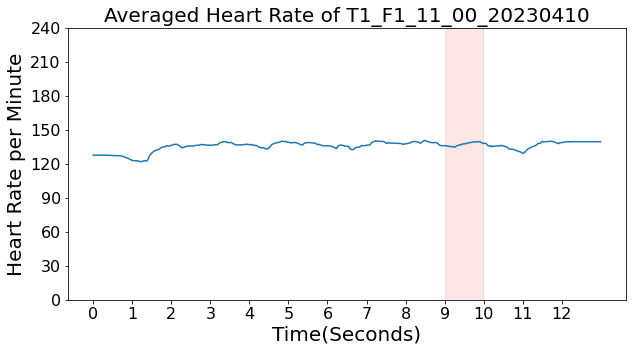

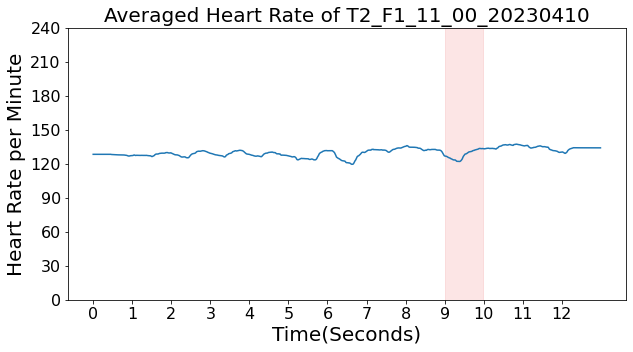

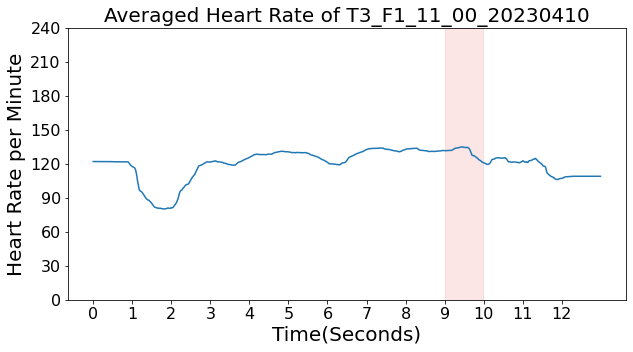

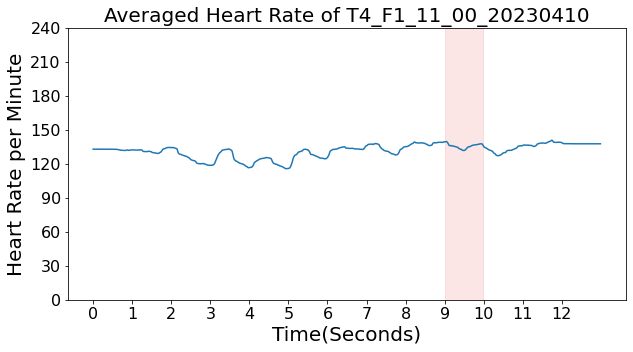

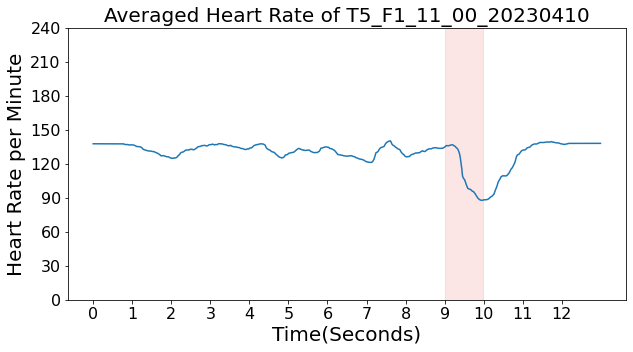

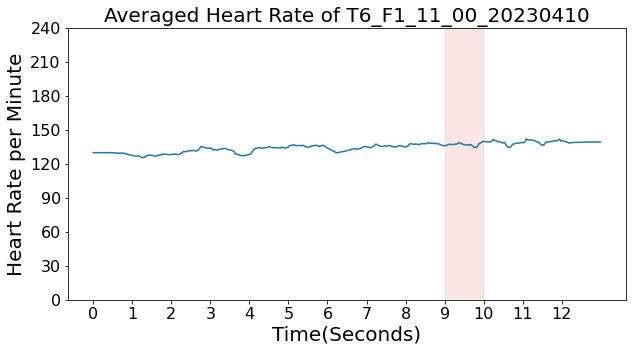

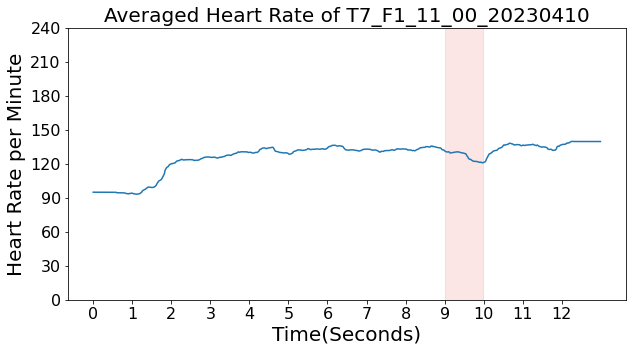

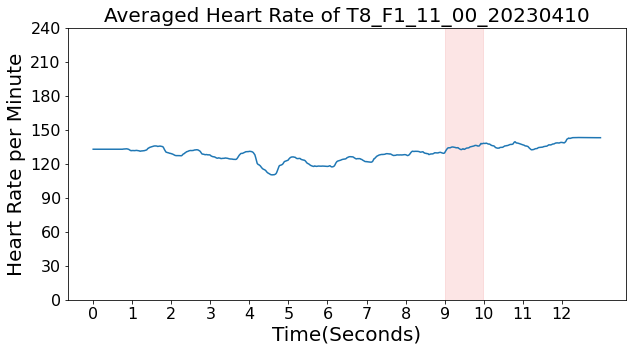

In [7]:
#1.Bradycardia Classification
#1.1 Draw ROIs in Fiji circling the entire heart
#1.2 create bradyinfo and get heart rate trace
#Provide Batch name and ROI lists (write ROI in the sequence of the folders)
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('E:/'+batch + '/*')
fish_dir_list = []
ROI_list = [[(249, 363, 80, 76),(99, 277, 90, 72),(88, 342, 122, 94),(102, 339, 177, 90)],
            [(100, 312, 122, 76),(96, 262, 94, 80),(77, 319, 119, 89),(100, 312, 134, 83),(144, 364, 106, 81),(72, 323, 109, 93)]]

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))
print(fish_dir_list)

'run single fish'
create_brady_info_pixelwise(fish_dir_list[1][0]+'/',ROI_list[1][0])

# 'run entire dataset'
# for date in range(0,len(fish_dir_list)):
#     for fish in range(0,len(fish_dir_list[date])):
#         create_brady_info_pixelwise(fish_dir_list[date][fish]+'/',ROI_list[date][fish])

In [ ]:
#1.3 classify whether each trial has bradycardia
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('E:/'+batch + '/*')
fish_dir_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))
print(fish_dir_list)

for date in range(0,len(fish_dir_list)):
    for fish in range(0,len(fish_dir_list[date])):
        bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
        bradyinfo = pd.read_excel(bradyinfo_path[0])
        heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
        
        "run whole fish bradycardia classification"
        n_neighbors=7
        max_warping_window=40
        brady_result = bradycardia_detection(np.array(heart_rate_dataframe),'training_set_X.npy','training_set_Y.npy',n_neighbors0= n_neighbors, max_warping_window0=max_warping_window)
    
        bradyinfo['Bradycardia_Classification'] = brady_result
        bradyinfo['Bradycardia_Classification_n_neighbor'] = n_neighbors
        bradyinfo['Bradycardia_Classification_max_warping_window'] = max_warping_window
        
        writer = pd.ExcelWriter(bradyinfo_path[0], engine='xlsxwriter')
        bradyinfo.to_excel(writer, sheet_name='Bradyinfo',index = False)
        heart_rate_dataframe.to_excel(writer, sheet_name='heart_rate_trace',index = False)
        writer.save()



In [ ]:
#2.Strike Detection
#2.1 Draw ROI above fish head that the head enters during strike
#2.2 Run strike detection fish by fish and check the result
#2.3 store strike detection result in bradyinfo
#Provide Batch name and ROI list
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('E:/'+batch + '/*')
fish_dir_list = []

ROI_list = [[(523, 128, 2, 2),(473, 64, 2, 2),(476, 151, 2, 2),(505, 158, 2, 2)],
            [(521, 157, 2, 2),(463, 86, 2, 3),(500, 160, 2, 2),(474, 96, 2, 2),(503, 157, 2, 2)
             ,(448, 138, 2, 2)]]

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))
print(fish_dir_list)

'run single fish'
strike_screening(fish_dir_list[1][5]+ '/' ,ROI_list[1][5],duration=1250, low_thresh=0, high_thresh=1, sigma=3)

'run all fish not recommended'
# for date in range(0,len(fish_dir_list)):
#     for fish in range(0,len(fish_dir_list[date])):
#         strike_screening(fish_dir_list[date][fish]+ '/' ,ROI_list[date][fish],duration=1250, low_thresh=2, high_thresh=3, sigma=4)

In [ ]:
#3. PC Detection
#3.1 Use Ztrack to track the eye and tail angles
#3.2 Use eye angles of each fish to fit bimodal distribution and find threshold
#find all fish folders
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('E:/'+batch + '/*')
fish_dir_list = []
Threshold_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))
print(fish_dir_list)

#First check the bimodel distribution of eye angles and find a threshold
for date in range(0,len(fish_dir_list)):
    for fish in range(0,len(fish_dir_list[date])):
        eye_angle_df, threshold = get_bimodel_distribution(fish_dir_list[date][fish])
        Threshold_list.append(threshold)
print(Threshold_list)

In [ ]:
Threshold_list

In [ ]:
#the second step is to manually check all threshold and correct the wrong ones
Threshold_list = [[23,26,28,18],[30,23,44,33,30,38]]

for date in range(0,len(fish_dir_list)):
    for fish in range(0,len(fish_dir_list[date])):
        bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
        bradyinfo = pd.read_excel(bradyinfo_path[0])
        heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
        
        threshold = Threshold_list[date][fish]
        draw_threshold(fish_dir_list[date][fish],threshold,bandwidth = 2)
        
        bradyinfo['PC_Threshold'] = [threshold] * bradyinfo.shape[0]
        
        writer = pd.ExcelWriter(bradyinfo_path[0], engine='xlsxwriter')
        bradyinfo.to_excel(writer, sheet_name='Bradyinfo',index = False)
        heart_rate_dataframe.to_excel(writer, sheet_name='heart_rate_trace',index = False)
        writer.save()

In [ ]:
#3.3 Detect PC in each trials
#the thrid step is to use threshold to find PC trials
for date in range(0,len(fish_dir_list)):
    for fish in range(0,len(fish_dir_list[date])):
        bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
        bradyinfo = pd.read_excel(bradyinfo_path[0])
        heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
        
        PC_trial, PC_interval = get_pc_trial(fish_dir_list[date][fish],bradyinfo.PC_Threshold[0])
        bradyinfo['PC_trial'] = PC_trial
        bradyinfo['PC_interval'] = PC_interval
        #3.4 Store PC result in Bradyinfo
        writer = pd.ExcelWriter(bradyinfo_path[0], engine='xlsxwriter')
        bradyinfo.to_excel(writer, sheet_name='Bradyinfo',index = False)
        heart_rate_dataframe.to_excel(writer, sheet_name='heart_rate_trace',index = False)
        writer.save()
        writer.close()

In [ ]:
#4. Tail Angle Detection (Priliminary)
#4.1 crop 2 ROIs in video left to right of tail resting position
#Provide Batch name and ROI list
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('E:/'+batch + '/*')
fish_dir_list = []

ROI_list = [[(269, 448, 3, 5),(268, 448, 3, 6),(278, 442, 6, 9),(282, 459, 6, 7)],
            [(259, 455, 5, 12),(261, 452, 4, 14),(258, 457, 5, 7),(259, 429, 4, 11),(264, 461, 19, 8)
             ,(273, 461, 7, 9)]]

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))
print(fish_dir_list)


'run single fish'
swim_screening(fish_dir_list[1][5]+ '/',ROI_list[1][5],duration=1250, low_thresh=0.5, high_thresh=1.5, sigma=1)

'run all fish not recommended'
# for date in range(0,len(fish_dir_list)):
#     for fish in range(0,len(fish_dir_list[date])):
#         strike_screening(fish_dir_list[date][fish]+ '/' ,ROI_list[date][fish],duration=1250, low_thresh=0.5, high_thresh=1, sigma=1)

In [ ]:
#Manual Correction
#step 1: first manually check all brady trials + strikes from bradyinfo and correct it in excel file
#step 2: manually check PC trials from bradyinfo and correct
#step 3: check stimulus sequence and correct manually and save to a new file end with _correction

[['D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F4_17_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F5_19_00'], ['D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F6_19_30'], [], ['D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F1_10_40', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F2_12_20', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F6_20_00'], ['D:/LCr_UV_HSA_Lum_Low_1\\20230313/behavior\\F1_10_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230313/b

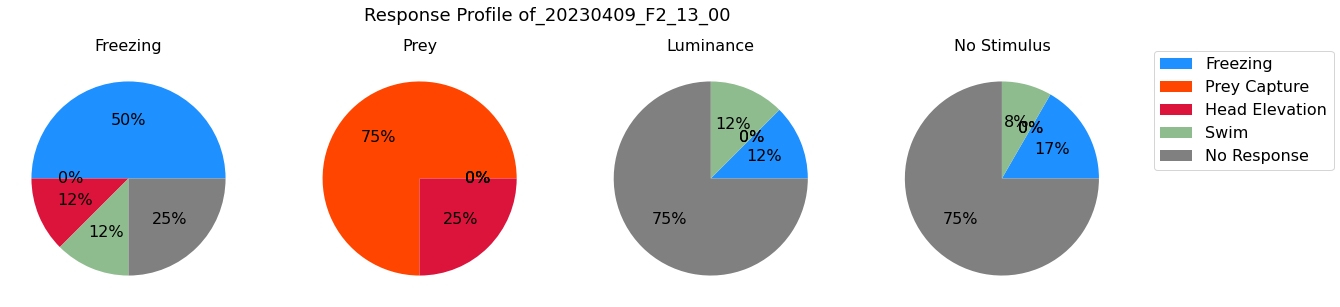

F5_19_00
20230409


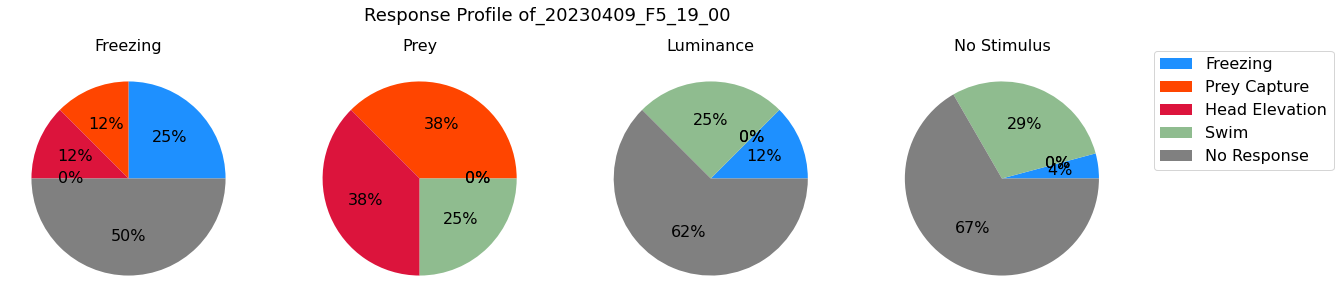

F6_19_30
20230410


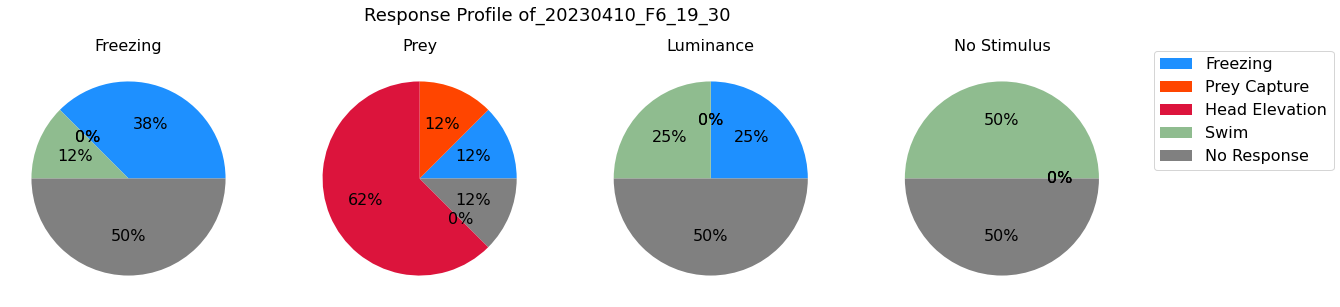

F1_10_40
20230312


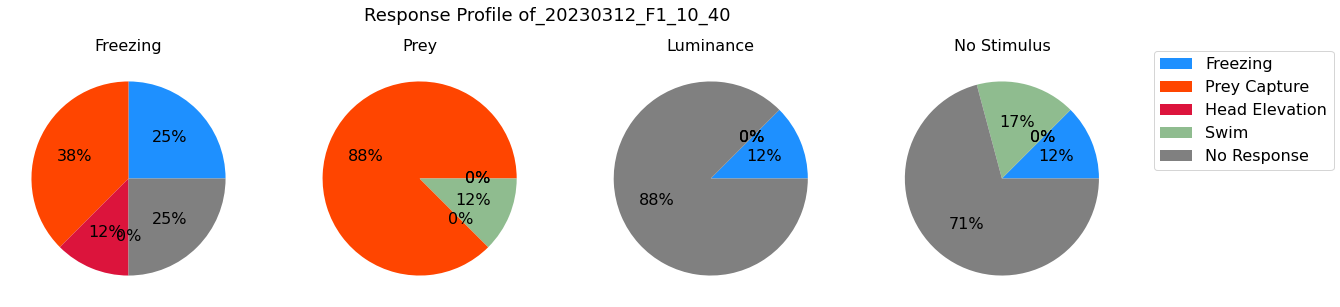

F2_12_20
20230312


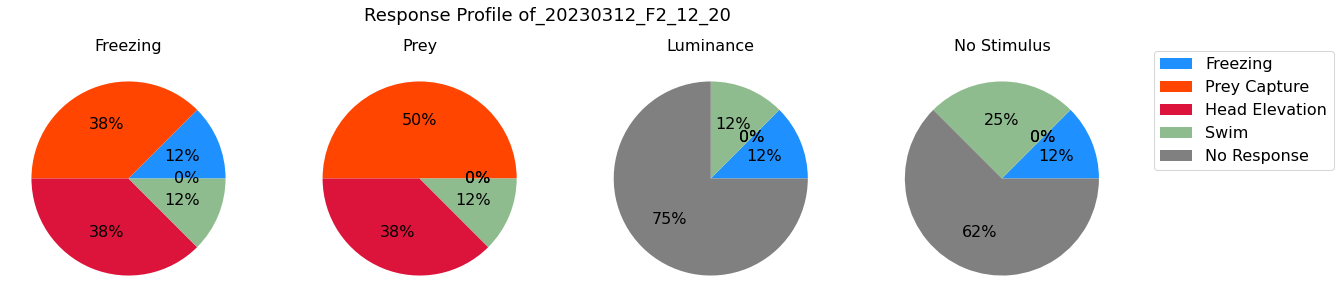

F5_18_00
20230312


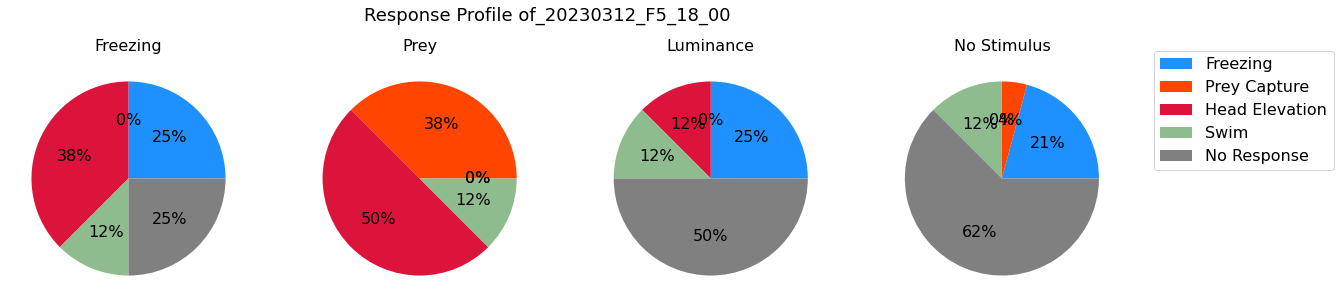

F6_20_00
20230312


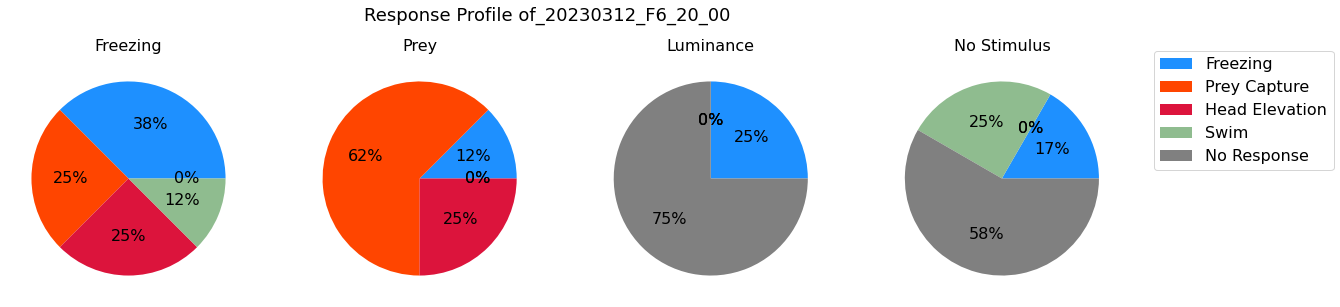

In [15]:
#5.1 Individual Fish Pie Chart of response: Freeze, PC, Strikes, Escape, Other Swim, No Response
# pie chart of each fish(auto_label)
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('D:/'+batch + '/*')
fish_dir_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

batch = 'LCr_UV_HSA_Lum_Low_1'
date_list = glob.glob('D:/'+batch + '/*')

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

print(fish_dir_list)

stimulus_list = ['Freezing','Prey','Luminance','No Stimulus']
bar_plot_num = []

for date,fish in ([0,1],[0,3],[1,5],[3,0],[3,1],[3,4],[3,5]):
    fish_str = fish_dir_list[date][fish][-8:]
    print(fish_str)
    date_str = fish_dir_list[date][fish][-26:-18]
    print(date_str)

    bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
    Brady_info = pd.read_excel(bradyinfo_path[0])
    heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
    vsinfo_dir = glob.glob(fish_dir_list[date][fish] + '/vsinfo*')
    vsinfo = pd.read_excel(vsinfo_dir[0])
    Behavior_List = []

#         for t in range(0,vsinfo.shape[0]):
#             if Brady_info.Bradycardia_Classification[t] == 1:
#                 Behavior_List.append('Freezing')
#             if Brady_info.Bradycardia_Classification[t] == 0:
#                 Behavior_List.append('No_Response')

    for t in range(0,vsinfo.shape[0]):
        if Brady_info.Bradycardia_Classification[t] == 1 and Brady_info.PC_trial[t]== True:
            Behavior_List.append('Strike')
        if Brady_info.PC_trial[t] == True and Brady_info.Bradycardia_Classification[t] == 0:
            Behavior_List.append('Prey_Capture')
        if Brady_info.PC_trial[t] == False:
            if Brady_info.Swim[t] == True or  Brady_info.Strike_Bouts[t] == True:
                Behavior_List.append('Swim')
            if Brady_info.Swim[t] == False and  Brady_info.Strike_Bouts[t] == False:
                if Brady_info.Bradycardia_Classification[t] == 1:
                    Behavior_List.append('Freezing')
                if Brady_info.Bradycardia_Classification[t] == 0:
                    Behavior_List.append('No_Response')

    Brady_info['Behavior_Classification'] = Behavior_List

    writer = pd.ExcelWriter(bradyinfo_path[0], engine='xlsxwriter')
    Brady_info.to_excel(writer, sheet_name='Bradyinfo',index = False)
    heart_rate_dataframe.to_excel(writer, sheet_name='heart_rate_trace',index = False)
    writer.save()
    writer.close()

    NoOfTrial_Freezing = [0,0,0,0]
    NoOfTrial_Prey_Capture = [0,0,0,0]
    NoOfTrial_Strike = [0,0,0,0]
    NoOfTrial_Swim = [0,0,0,0]
    NoOfTrial_No_Response = [0,0,0,0]


    for t in range(0,vsinfo.shape[0]):
        if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
            locals()['NoOfTrial_'+str(Brady_info.Behavior_Classification[t])][3] += 1
        if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
            if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 20:
                locals()['NoOfTrial_'+str(Brady_info.Behavior_Classification[t])][0] += 1
            if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                locals()['NoOfTrial_'+str(Brady_info.Behavior_Classification[t])][1] += 1
        if vsinfo.Left_Stimulus_Type[t] == 'lum' or vsinfo.Right_Stimulus_Type[t] == 'lum':
            locals()['NoOfTrial_'+str(Brady_info.Behavior_Classification[t])][2] += 1

    bar_plot_num.append([NoOfTrial_Freezing,NoOfTrial_Prey_Capture,NoOfTrial_Strike,NoOfTrial_Swim,NoOfTrial_No_Response])


    #define Seaborn color palette to use
    colors = ['dodgerblue','orangered','crimson','darkseagreen','grey']
    labels = ['Freezing','Prey Capture','Head Elevation','Swim','No Response']

    fig, ((ax1, ax2, ax3,ax4)) = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)
    ax_list= [ax1,ax2,ax3,ax4]

    for i in range(0,4):
        ax_list[i].pie([NoOfTrial_Freezing[i],NoOfTrial_Prey_Capture[i],NoOfTrial_Strike[i],
                        NoOfTrial_Swim[i],NoOfTrial_No_Response[i]],  colors = colors, autopct='%.0f%%', textprops={'fontsize': 16})
        ax_list[i].set_title(stimulus_list[i],fontsize = 16)
    plt.legend(labels,loc='lower right', bbox_to_anchor=(1.9, 0.5),fontsize = 16)
    plt.suptitle('Response Profile of_' + date_str + '_' + fish_str,fontsize = 18,y = 0.8)
    plt.savefig(fish_dir_list[date][fish] + '//Response Profile of_' + date_str + '_' + fish_str + '.png',bbox_inches='tight')
    plt.show()

      stimulus  Freezing  Prey Capture  Head Elevation  Swim  No Response
0          15°        17             9              11     5           14
1           4°         2            29              19     5            1
2    Luminance        10             0               1     7           38
3  No Stimulus        20             1               0    40          107
      stimulus  Freezing  Prey Capture  Head Elevation      Swim  No Response
0          15°  0.303571      0.160714        0.196429  0.089286     0.250000
1           4°  0.035714      0.517857        0.339286  0.089286     0.017857
2    Luminance  0.178571      0.000000        0.017857  0.125000     0.678571
3  No Stimulus  0.119048      0.005952        0.000000  0.238095     0.636905


<ipython-input-16-065d3350d970>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%','0%','20%','40%','60%','80%','100%'],fontsize = 14)


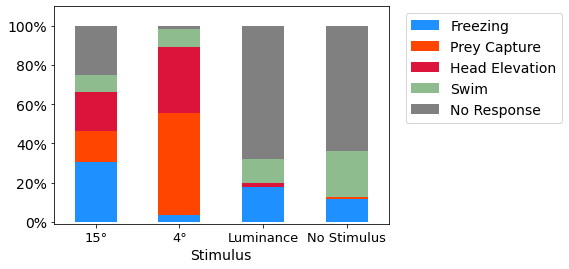

In [16]:
stimulus_list = ['15°','4°','Luminance','No Stimulus']
labels = ['Freezing','Prey Capture','Head Elevation','Swim','No Response']
df_count = pd.DataFrame()
df_count['stimulus'] = stimulus_list

for a in range(0,len(labels)):
    count = [0,0,0,0]
    for f in range(0,len(bar_plot_num)):
        for i in range(0,len(stimulus_list)):
            count[i] = bar_plot_num[f][a][i] + count[i]
    
    df_count[labels[a]] = count
print(df_count)

for i in range(0,df_count.shape[0]):
    a = list(df_count.iloc[i,1:])
    base = sum(a)
    for k in range(0,len(a)):
        a[k] = a[k]/base
    df_count.iloc[i,1:] = a
print(df_count)

ax = df_count.plot(
    x = 'stimulus',
    kind = 'bar',
    stacked = True,
    title = '',
    mark_right = True,
    color = colors)
plt.ylim(-0.01,1.1)
plt.legend(bbox_to_anchor=(1.03, 1),fontsize = 14)
plt.xticks(rotation = 0,fontsize = 13)
ax.set_yticklabels(['0%','0%','20%','40%','60%','80%','100%'],fontsize = 14)
plt.xlabel('Stimulus',fontsize = 14)
plt.show()

      stimulus  Freezing  Prey Capture  Swim  No Response
0          15°        17             9     5           14
1           4°         2            29     5            1
2    Luminance        10             0     7           38
3  No Stimulus        20             1    40          107
      stimulus  Freezing  Prey Capture      Swim  No Response
0          15°  0.377778      0.200000  0.111111     0.311111
1           4°  0.054054      0.783784  0.135135     0.027027
2    Luminance  0.181818      0.000000  0.127273     0.690909
3  No Stimulus  0.119048      0.005952  0.238095     0.636905


<ipython-input-17-3d063aba18af>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0%','0%','20%','40%','60%','80%','100%'],fontsize = 14)


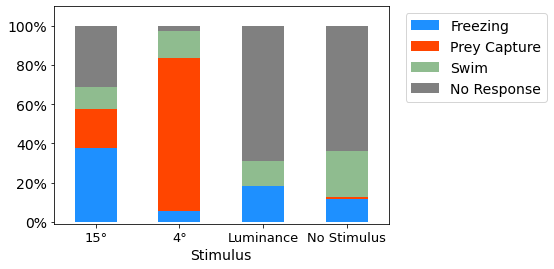

In [17]:
#percentage of strike excluded
stimulus_list = ['15°','4°','Luminance','No Stimulus']
labels = ['Freezing','Prey Capture','Head Elevation','Swim','No Response']
df_count = pd.DataFrame()
df_count['stimulus'] = stimulus_list

for a in (0,1,3,4):
    count = [0,0,0,0]
    for f in range(0,len(bar_plot_num)):
        for i in range(0,len(stimulus_list)):
            count[i] = bar_plot_num[f][a][i] + count[i]
    
    df_count[labels[a]] = count
print(df_count)

for i in range(0,df_count.shape[0]):
    a = list(df_count.iloc[i,1:])
    base = sum(a)
    for k in range(0,len(a)):
        a[k] = a[k]/base
    df_count.iloc[i,1:] = a
print(df_count)

color_no_strike = ['dodgerblue','orangered','darkseagreen','grey']

ax = df_count.plot(
    x = 'stimulus',
    kind = 'bar',
    stacked = True,
    title = '',
    mark_right = True,
    color = color_no_strike )
plt.ylim(-0.01,1.1)
plt.legend(bbox_to_anchor=(1.03, 1),fontsize = 14)
plt.xticks(rotation = 0,fontsize = 13)
ax.set_yticklabels(['0%','0%','20%','40%','60%','80%','100%'],fontsize = 14)
plt.xlabel('Stimulus',fontsize = 14)
plt.show()

In [37]:
#5.2 Averaged Heart Rate for each stimulus
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('D:/'+batch + '/*')
fish_dir_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

batch = 'LCr_UV_HSA_Lum_Low_1'
date_list = glob.glob('D:/'+batch + '/*')

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

print(fish_dir_list)

stimulus_list = ['No_Stimulus','Freezing','Prey','Luminance']

for s in stimulus_list:
    locals()['Trace_' + s] = []

for date,fish in ([0,1],[0,3],[1,5],[3,0],[3,1],[3,4],[3,5]):
    fish_str = fish_dir_list[date][fish][-8:]
    print(fish_str)
    date_str = fish_dir_list[date][fish][-26:-18]
    print(date_str)

    bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
    Brady_info = pd.read_excel(bradyinfo_path[0])
    heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
    vsinfo_dir = glob.glob(fish_dir_list[date][fish] + '/vsinfo*')
    vsinfo = pd.read_excel(vsinfo_dir[0])

    for t in range(0,vsinfo.shape[0]):
        if Brady_info.Behavior_Classification[t] != 'Strike':
            normalized_trace = heart_rate_dataframe.iloc[t,:]/np.mean(heart_rate_dataframe.iloc[t,300:899])

            if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
                Trace_No_Stimulus.append(normalized_trace)
            if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 20:
                    Trace_Freezing.append(normalized_trace)
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                    Trace_Prey.append(normalized_trace)
            if vsinfo.Left_Stimulus_Type[t] == 'lum' or vsinfo.Right_Stimulus_Type[t] == 'lum':
                Trace_Luminance.append(normalized_trace)
for s in stimulus_list:
    print('the number of ' + s + ' trial is ' + str(len(locals()['Trace_' + s])))

[['D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F4_17_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F5_19_00'], ['D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F6_19_30'], [], ['D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F1_10_40', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F2_12_20', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F6_20_00'], ['D:/LCr_UV_HSA_Lum_Low_1\\20230313/behavior\\F1_10_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230313/b

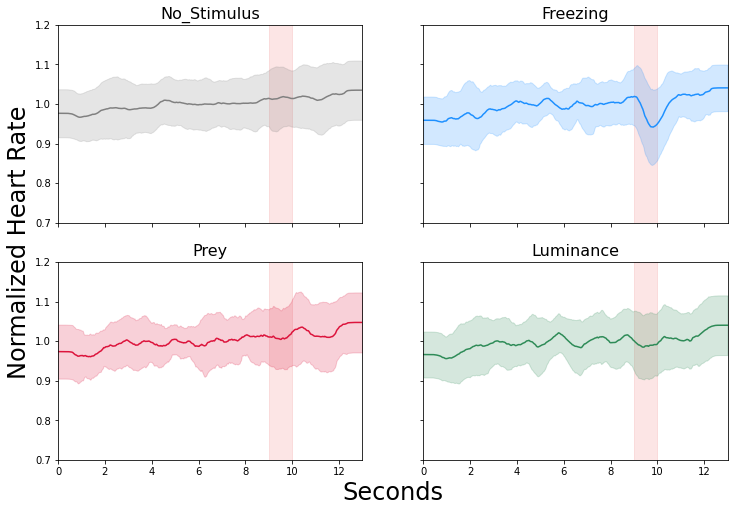

In [38]:
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
x = np.arange(1300)/100
ax_list= [ax1,ax2,ax3,ax4]

color_list = ['grey','dodgerblue','crimson','seagreen']

for ax,c,color in zip(ax_list,stimulus_list,color_list):
    avg = []
    std = []
    std_plus = []
    std_minus = []
    for t in range(0,len(locals()['Trace_' + c][0])):
        frame_hr = []
        for l in range(0,len(locals()['Trace_' + c])):
            frame_hr.append(locals()['Trace_' + c][l][t])
        avg.append(np.mean(frame_hr))
        std.append(np.std(frame_hr))
        std_plus.append(np.mean(frame_hr)+ np.std(frame_hr))
        std_minus.append(np.mean(frame_hr) - np.std(frame_hr))
    ax.plot(x,avg,linewidth = 1.5,c = color)
    x1 = np.arange(900,1000)/100
    ax.fill_between(x1,2,-2,linewidth = 1,color = 'lightcoral',alpha = 0.2)
    ax.fill_between(x,std_minus,std_plus,color = color,linewidth = 1,alpha = 0.2)
    ax.set_title(str(c),fontsize =16)
plt.ylim(0.7,1.2)
plt.xlim(0,13)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Normalized Heart Rate",fontsize = 24)
plt.xlabel("Seconds",fontsize = 24)

plt.show()
# fig.savefig(fish_address + '//Heart Beat of'+ heart_list[f][-25:-17] + 'newnew.png',dpi=300)
# fig.savefig(main_dir+'\\Heart Beat fish_2fish.png',dpi=300)

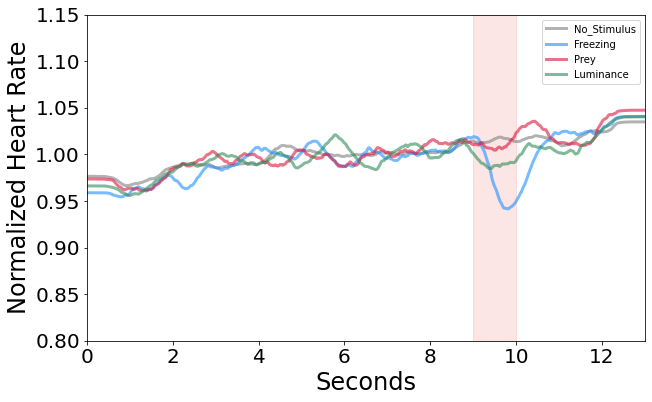

In [39]:
# overlay
plt.figure(figsize = (10,6))
#fig.suptitle('Heart Rate of ' + heart_list[f][-25:-17])
# fig.suptitle('Fish Heart Rate of different stimulus')
x = np.arange(1300)/100

# ax_list= [ax1,ax2,ax3,ax4,ax5,ax6]

for c,color in zip(stimulus_list,color_list):

    avg = []
    std = []
    std_plus = []
    std_minus = []
    for t in range(0,len(locals()['Trace_' + c][0])):
        frame_hr = []
        for l in range(0,len(locals()['Trace_' + c])):
            frame_hr.append(locals()['Trace_' + c][l][t])
        avg.append(np.mean(frame_hr))
        std.append(np.std(frame_hr))
        std_plus.append(np.mean(frame_hr)+ np.std(frame_hr))
        std_minus.append(np.mean(frame_hr) - np.std(frame_hr))
    plt.plot(x,avg,linewidth = 3,c = color,alpha = 0.6)
x1 = np.arange(900,1000)/100
plt.fill_between(x1,2,-2,linewidth = 1,color = 'lightcoral',alpha = 0.2)
plt.legend(['No_Stimulus','Freezing','Prey','Luminance'])
plt.ylim(0.80,1.15)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.xlim(0,13)
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Normalized Heart Rate",fontsize = 24)
plt.xlabel("Seconds",fontsize = 24)

plt.show()

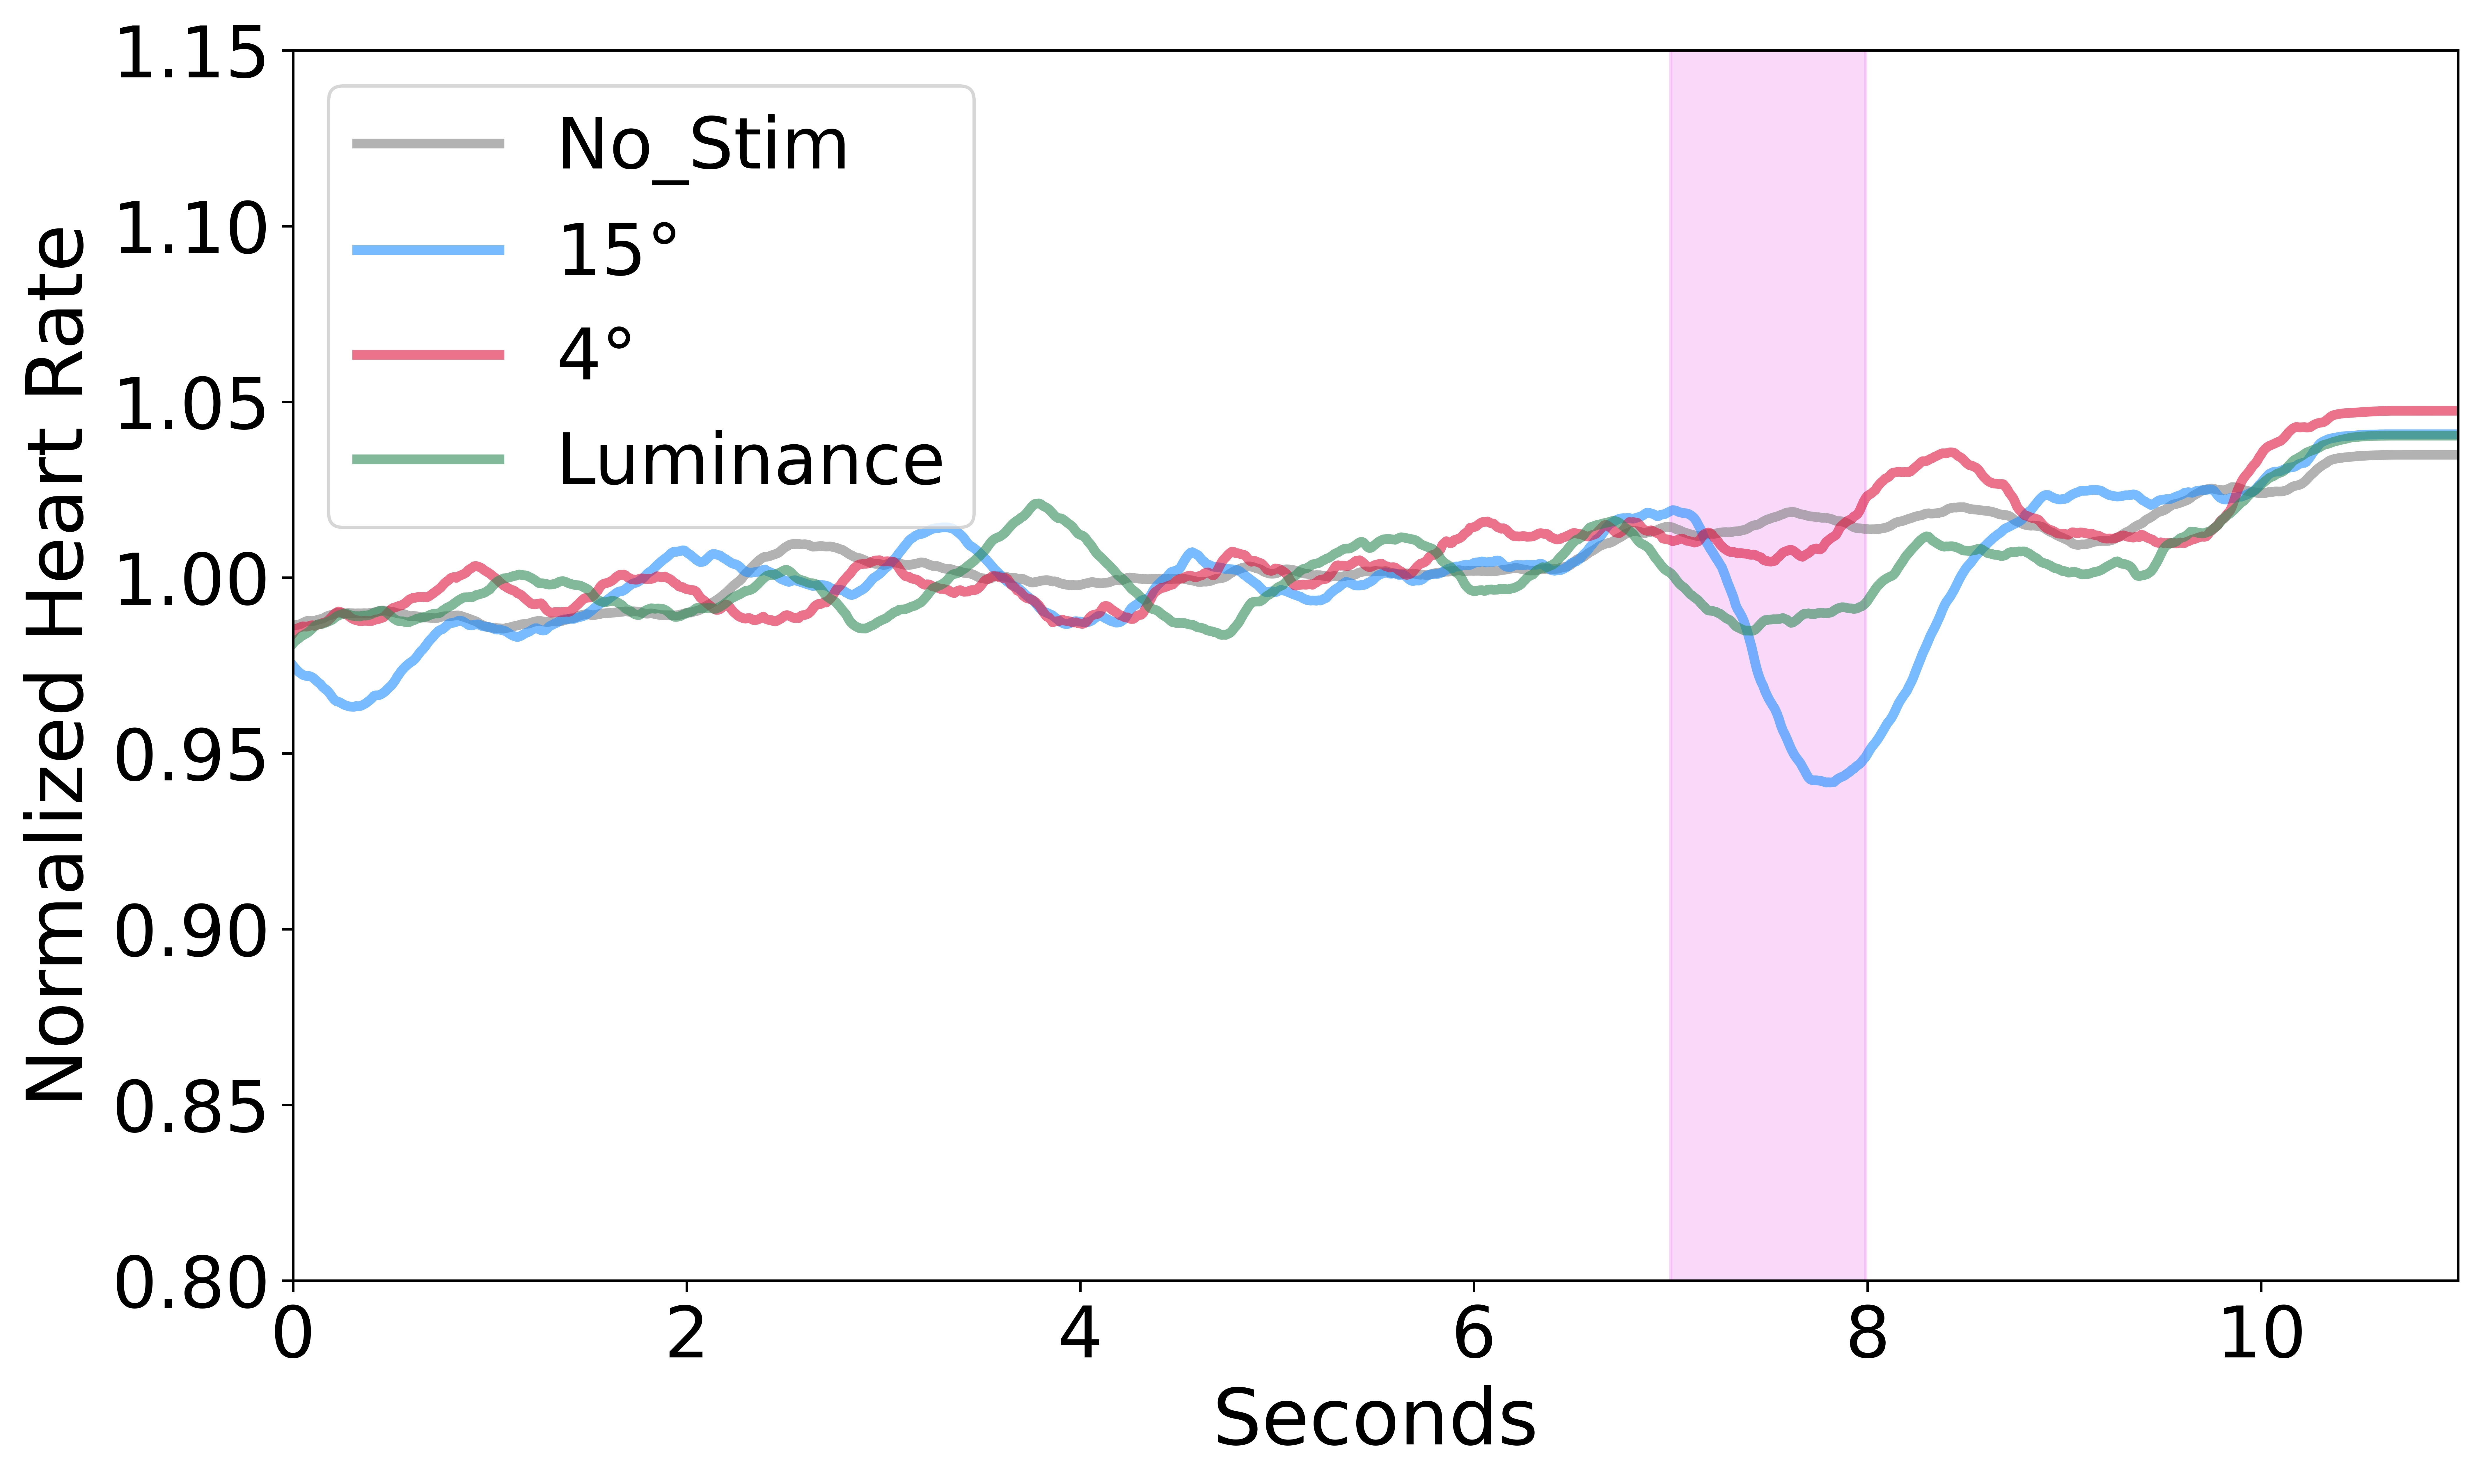

In [40]:
# overlay
plt.figure(figsize = (12,7),dpi = 800)
#fig.suptitle('Heart Rate of ' + heart_list[f][-25:-17])
# fig.suptitle('Fish Heart Rate of different stimulus')
x = np.arange(1100)/100

# ax_list= [ax1,ax2,ax3,ax4,ax5,ax6]

for c,color in zip(stimulus_list,color_list):

    avg = []
    std = []
    std_plus = []
    std_minus = []
    for t in range(200,len(locals()['Trace_' + c][0])):
        frame_hr = []
        for l in range(0,len(locals()['Trace_' + c])):
            frame_hr.append(locals()['Trace_' + c][l][t])
        avg.append(np.mean(frame_hr))
        std.append(np.std(frame_hr))
        std_plus.append(np.mean(frame_hr)+ np.std(frame_hr))
        std_minus.append(np.mean(frame_hr) - np.std(frame_hr))
    plt.plot(x,avg,linewidth = 3,c = color,alpha = 0.6)
x1 = np.arange(700,800)/100
plt.fill_between(x1,2,-2,linewidth = 1,color = 'violet',alpha = 0.3)
plt.legend(['No_Stim','15°','4°','Luminance'],fontsize=22,loc = 'upper left')
plt.ylim(0.80,1.15)
plt.yticks(fontsize = 22)
plt.xticks(fontsize = 22)
plt.xlim(0,11)
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Normalized Heart Rate",fontsize = 24)
plt.xlabel("Seconds",fontsize = 24)

plt.show()

No_Stimulus and Freezing: 0.006172943047055508
No_Stimulus and Prey: 0.7099343972140032
No_Stimulus and Luminance: 0.08191585015877294
Freezing and Prey: 0.07510425437160016
Freezing and Luminance: 0.34960578918522245
Prey and Luminance: 0.28596371390765685


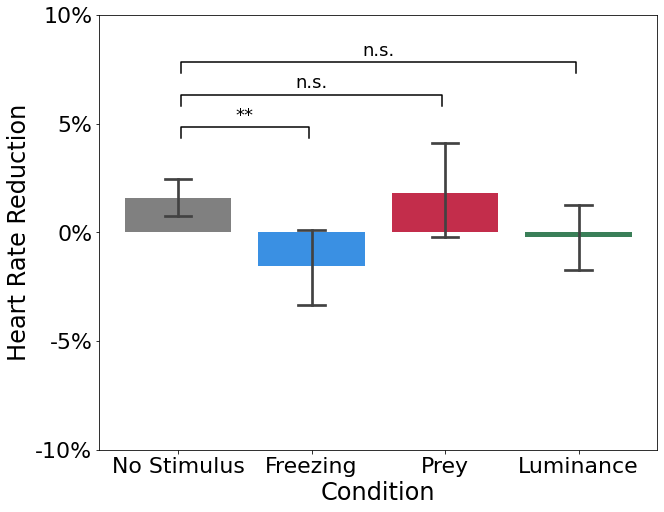

In [43]:
#5.3 Heart Rate Reduction of each condition
from scipy import integrate
df_avg_heart_rate = pd.DataFrame(columns = ['avg_value','min_value','category'])

for c in stimulus_list:
    locals()['brady' + c] = 0

for c in stimulus_list:
    for i in range(0,len(locals()['Trace_' + c])):
        df_value_no = df_avg_heart_rate.shape[0]
        df_avg_heart_rate.loc[df_value_no,'avg_value'] = -1+np.mean(locals()['Trace_' + c][i][900:1100])
        if df_avg_heart_rate.loc[df_value_no,'avg_value'] <= -0.04:
            locals()['brady' + c] += 1    
        df_avg_heart_rate.loc[df_value_no,'min_value'] = np.min(locals()['Trace_' + c][i][900:1100])
        df_avg_heart_rate.loc[df_value_no,'category'] = c
    
df_avg_heart_rate['avg_value'] = df_avg_heart_rate['avg_value'].astype(float)
df_avg_heart_rate['min_value'] = df_avg_heart_rate['min_value'].astype(float)
import seaborn as sns
import scipy
for c in stimulus_list:
    locals()['np_HR_'+c] = np.array(df_avg_heart_rate[df_avg_heart_rate['category'] == c]['avg_value']).astype(float)
# condition_list = ['m','lum','s','ns']
for i in range(0,len(stimulus_list)-1):
    con_i = stimulus_list[i]
    for j in range(i+1,len(stimulus_list)):
        con_j = stimulus_list[j]
        locals()['sig_'+str(con_i)+'_'+str(con_j)] = scipy.stats.mannwhitneyu(locals()['np_HR_'+str(con_i)], locals()['np_HR_'+str(con_j)], use_continuity=True, alternative='two-sided')[1]
        print(str(con_i)+' and '+str(con_j)+': '+str(locals()['sig_'+str(con_i)+'_'+str(con_j)]))

condition_list = stimulus_list
comparasion_pairs=[(0,1),(0,2),(0,3)] 
heights = [0.035,0.05,0.065,0.08,0.08]
    
def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "n.s."


plt.figure(figsize = (10,8))
ax = sns.barplot(x="category", y="avg_value", data=df_avg_heart_rate,capsize=.2,palette = color_list)
ax.set_xticklabels(['No Stimulus','Freezing','Prey','Luminance'],fontsize = 22)
ax.set_ylim((-0.1,0.1))
ax.set_ylabel('Heart Rate Reduction',fontsize = 24)
ax.set_xlabel('Condition',fontsize = 24)
plt.yticks([-0.1,-0.05,0,0.05,0.10],['-10%','-5%','0%','5%','10%'],fontsize =22)
plt.xticks(fontsize =22)


for i in range(0,len(comparasion_pairs)) :
    x_1, x_2 = comparasion_pairs[i][0],comparasion_pairs[i][1]
    con_i, con_j = condition_list[x_1], condition_list[x_2]
    sig_value = locals()['sig_'+str(con_i)+'_'+str(con_j)]
    
    y, h = np.array(df_avg_heart_rate['avg_value']).mean()+heights[i],0.005
    ax.plot([x_1+0.02, x_1+0.02, x_2-0.02, x_2-0.02], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x_1+x_2)*.5, y+h*1.25, stars(sig_value) , size = 18,ha='center', va='bottom', color='black')


# plt.savefig(main_dir+'\\averaged heart rate reduction of 2 seconds following stimulus.png')
plt.show()

In [26]:
#5.5 Tail movement Comparision: Tail Supression based on swim detection
#first, only select trials with swim during 0-9
#then plot it's averaged swimming probability per condition stacked in one plot just like OMR
#5.2 Averaged Heart Rate for each stimulus
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('D:/'+batch + '/*')
fish_dir_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

batch = 'LCr_UV_HSA_Lum_Low_1'
date_list = glob.glob('D:/'+batch + '/*')

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

print(fish_dir_list)

stimulus_list = ['No_Stimulus','Freezing','Prey','Luminance']

for s in stimulus_list:
    locals()['Trace_' + s] = []
for s in stimulus_list:
    locals()['Diff_' + s] = []

for date,fish in ([0,1],[0,3],[1,5],[3,0],[3,1],[3,4],[3,5]):
    fish_str = fish_dir_list[date][fish][-8:]
    print(fish_str)
    date_str = fish_dir_list[date][fish][-26:-18]
    print(date_str)

    bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
    Brady_info = pd.read_excel(bradyinfo_path[0])
    heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
    vsinfo_dir = glob.glob(fish_dir_list[date][fish] + '/vsinfo*')
    vsinfo = pd.read_excel(vsinfo_dir[0])

    for t in range(0,vsinfo.shape[0]):
        normalized_trace = np.zeros(1300)
        for b in eval(Brady_info.Swim_Bouts[t]):
            normalized_trace[b[0]:b[1]] = 1
        if np.average(normalized_trace[700:900]) > 0:
            print('trial'+str(t+1))
            difference = 200 * (np.average(normalized_trace[900:1100]) - np.average(normalized_trace[700:900]))
            if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
                Trace_No_Stimulus.append(normalized_trace)
                Diff_No_Stimulus.append(difference)
            if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 20:
                    Trace_Freezing.append(normalized_trace)
                    Diff_Freezing.append(difference)
                if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                    Trace_Prey.append(normalized_trace)
                    Diff_Prey.append(difference)
            if vsinfo.Left_Stimulus_Type[t] == 'lum' or vsinfo.Right_Stimulus_Type[t] == 'lum':
                Trace_Luminance.append(normalized_trace)
                Diff_Luminance.append(difference)
for s in stimulus_list:
    print('the number of ' + s + ' trial is ' + str(len(locals()['Trace_' + s])))


[['D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F4_17_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F5_19_00'], ['D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F6_19_30'], [], ['D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F1_10_40', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F2_12_20', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F6_20_00'], ['D:/LCr_UV_HSA_Lum_Low_1\\20230313/behavior\\F1_10_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230313/b

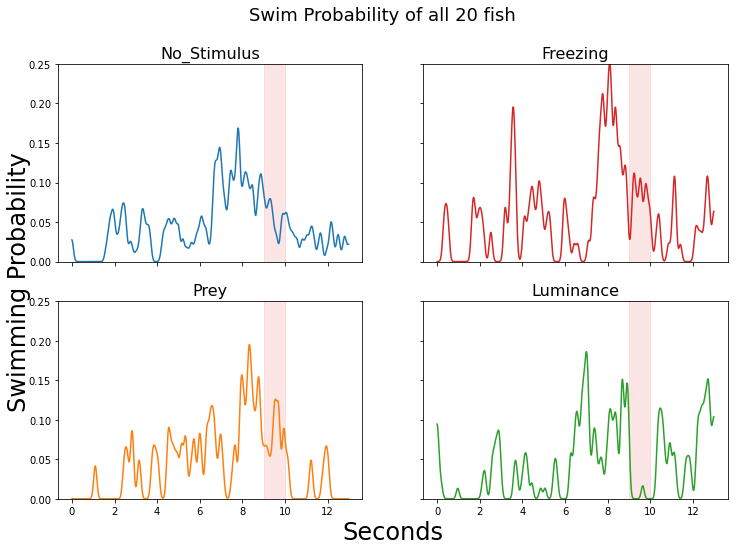

In [27]:
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
x = np.arange(1300)/100
ax_list= [ax1,ax2,ax3,ax4]

color_list = [sns.color_palette('tab10')[0],sns.color_palette('tab10')[3],sns.color_palette('tab10')[1],sns.color_palette('tab10')[2]]

for ax,c,color in zip(ax_list,stimulus_list,color_list):
    avg = []
    std = []
    std_plus = []
    std_minus = []
    for t in range(0,len(locals()['Trace_' + c][0])):
        frame_hr = []
        for l in range(0,len(locals()['Trace_' + c])):
            frame_hr.append(locals()['Trace_' + c][l][t])
        avg.append(np.mean(frame_hr))
        std.append(np.std(frame_hr))
        std_plus.append(np.mean(frame_hr)+ np.std(frame_hr))
        std_minus.append(np.mean(frame_hr) - np.std(frame_hr))
    ax.plot(x,gaussian_filter(avg,sigma = 7),linewidth = 1.5,c = color)
    x1 = np.arange(900,1000)/100
    ax.fill_between(x1,2,-2,linewidth = 1,color = 'lightcoral',alpha = 0.2)
#     ax.fill_between(x,std_minus,std_plus,color = color,linewidth = 1,alpha = 0.2)
    ax.set_title(str(c),fontsize =16)
plt.ylim(0,0.25)
# plt.xlim(0,13)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Swimming Probability",fontsize = 24)
plt.xlabel("Seconds",fontsize = 24)
plt.suptitle('Swim Probability of all 20 fish',fontsize = 18)
plt.show()
# fig.savefig(fish_address + '//Heart Beat of'+ heart_list[f][-25:-17] + 'newnew.png',dpi=300)
# fig.savefig(main_dir+'\\Heart Beat fish_2fish.png',dpi=300)

No_Stimulus and Freezing: 0.2855253185727229
No_Stimulus and Prey: 0.53119512926048
No_Stimulus and Luminance: 0.732255354617048
Freezing and Prey: 0.12023548244722747
Freezing and Luminance: 0.3793566134577595
Prey and Luminance: 0.4042341951051426


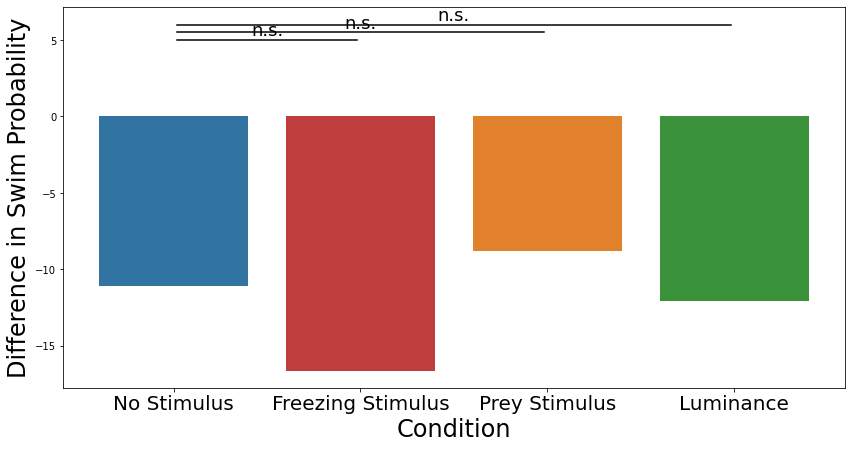

In [28]:
value_list = []
data_list = []
for s in stimulus_list:
    value_list.append(np.average(locals()['Diff_' + s]))
    data_list.append(locals()['Diff_' + s])
for i in range(0,len(stimulus_list)-1):
    con_i = stimulus_list[i]
    for j in range(i+1,len(stimulus_list)):
        con_j = stimulus_list[j]
        locals()['sig_'+str(con_i)+'_'+str(con_j)] = scipy.stats.mannwhitneyu(locals()['Diff_' + con_i], locals()['Diff_' + con_j], use_continuity=True, alternative='two-sided')[1]
        print(str(con_i)+' and '+str(con_j)+': '+str(locals()['sig_'+str(con_i)+'_'+str(con_j)]))

condition_list = stimulus_list
comparasion_pairs=[(0,1),(0,2),(0,3)] 
heights = [5,5.5,6,0.8,0.8]
    
def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "n.s."
  
plt.figure(figsize = (14,7))
ax = sns.barplot(stimulus_list,value_list,capsize=.3,palette = color_list)
# ax.scatter(data_list)
# ax = sns.stripplot(stimulus_list,value_list,color = 'k',alpha = 0.6,jitter = 0.2)
ax.set_xticklabels(['No Stimulus','Freezing Stimulus','Prey Stimulus','Luminance',],fontsize = 24)
# ax.set_ylim((-0.18,0.18))
ax.set_ylabel('Difference in Swim Probability',fontsize = 24)
ax.set_xlabel('Condition',fontsize = 24)
# plt.yticks([-0.1,-0.05,0.0,0.05,0.10],['-10%','-5%','0%','5%','10%'],fontsize =20)
plt.xticks(fontsize =20)

for i in range(0,len(comparasion_pairs)) :
    x_1, x_2 = comparasion_pairs[i][0],comparasion_pairs[i][1]
    con_i, con_j = condition_list[x_1], condition_list[x_2]
    sig_value = locals()['sig_'+str(con_i)+'_'+str(con_j)]
    
    y, h = np.array(df_avg_heart_rate['avg_value']).mean()+heights[i],0.005
    ax.plot([x_1+0.02, x_1+0.02, x_2-0.02, x_2-0.02], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x_1+x_2)*.5, y+h*1.25, stars(sig_value) , size = 18,ha='center', va='bottom', color='black')

In [45]:
#5.2 Averaged Heart Rate for each stimulus
batch = 'LCr_UV_HSA_Lum_Low_2'
date_list = glob.glob('D:/'+batch + '/*')
fish_dir_list = []

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

batch = 'LCr_UV_HSA_Lum_Low_1'
date_list = glob.glob('D:/'+batch + '/*')

for date in date_list:
    fish_dir_list.append(glob.glob(date + '/behavior/[!C]*'))

print(fish_dir_list)

stimulus_list = ['No_Stimulus','Freezing','Prey','Strike']

for s in stimulus_list:
    locals()['Trace_' + s] = []

for date,fish in ([0,1],[0,3],[1,5],[3,0],[3,1],[3,4],[3,5]):
# for date in range(0,len(fish_dir_list)):
#     for fish in range(0,len(fish_dir_list[date])):
    fish_str = fish_dir_list[date][fish][-8:]
    print(fish_str)
    date_str = fish_dir_list[date][fish][-26:-18]
    print(date_str)

    bradyinfo_path = glob.glob(fish_dir_list[date][fish] + '/Brady*')
    Brady_info = pd.read_excel(bradyinfo_path[0])
    heart_rate_dataframe= pd.read_excel(bradyinfo_path[0], sheet_name='heart_rate_trace')
    vsinfo_dir = glob.glob(fish_dir_list[date][fish] + '/vsinfo*')
    vsinfo = pd.read_excel(vsinfo_dir[0])

    for t in range(0,vsinfo.shape[0]):
        normalized_trace = heart_rate_dataframe.iloc[t,:]/np.mean(heart_rate_dataframe.iloc[t,300:899])
    #             if Brady_info.Behavior_Classification[t] == 'No_Response':
    #                 Trace_No_Stimulus.append(normalized_trace)
#             if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
#                 Trace_No_Stimulus.append(normalized_trace)
# #             if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
#         #             if Brady_info.Behavior_Classification[t] == 'No_Response':
#         #                 Trace_No_Stimulus.append(normalized_trace)
#             if Brady_info.Behavior_Classification[t] == 'Strike':
#                 Trace_Strike.append(normalized_trace)
#             if  Brady_info.Behavior_Classification[t] == 'Prey_Capture':
#                 Trace_Prey.append(normalized_trace)
#             if Brady_info.Behavior_Classification[t] == 'Freezing':
#                 Trace_Freezing.append(normalized_trace)
#         #                 if Brady_info.Strike_Bouts[t] == 1:
#         #                     Trace_Strike.append(normalized_trace)
#         #                 if Brady_info.Strike_Bouts[t] == 0:
#         #                     Trace_Prey.append(normalized_trace)
        if vsinfo.Left_Stimulus_Type[t] == 'n' and vsinfo.Right_Stimulus_Type[t] == 'n':
            Trace_No_Stimulus.append(normalized_trace)
#             if Brady_info.Strike_Bouts[t] == 1:
#                 Trace_Strike.append(normalized_trace)
        if vsinfo.Left_Stimulus_Type[t] == 'm' or vsinfo.Right_Stimulus_Type[t] == 'm':
            if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 20:
                if Brady_info.Strike_Bouts[t] == 0:
                    Trace_Freezing.append(normalized_trace)
            if vsinfo.Left_Stimulus_Size[t] + vsinfo.Right_Stimulus_Size[t] == 4:
                if Brady_info.Strike_Bouts[t] == 0:
                    Trace_Prey.append(normalized_trace)
                if Brady_info.Strike_Bouts[t] == 1:
                    Trace_Strike.append(normalized_trace)
for s in stimulus_list:
    print('the number of ' + s + ' trial is ' + str(len(locals()['Trace_' + s])))
    



[['D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F4_17_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230409/behavior\\F5_19_00'], ['D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F1_11_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F2_13_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_2\\20230410/behavior\\F6_19_30'], [], ['D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F1_10_40', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F2_12_20', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F3_14_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F4_16_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F5_18_00', 'D:/LCr_UV_HSA_Lum_Low_1\\20230312/behavior\\F6_20_00'], ['D:/LCr_UV_HSA_Lum_Low_1\\20230313/behavior\\F1_10_30', 'D:/LCr_UV_HSA_Lum_Low_1\\20230313/b

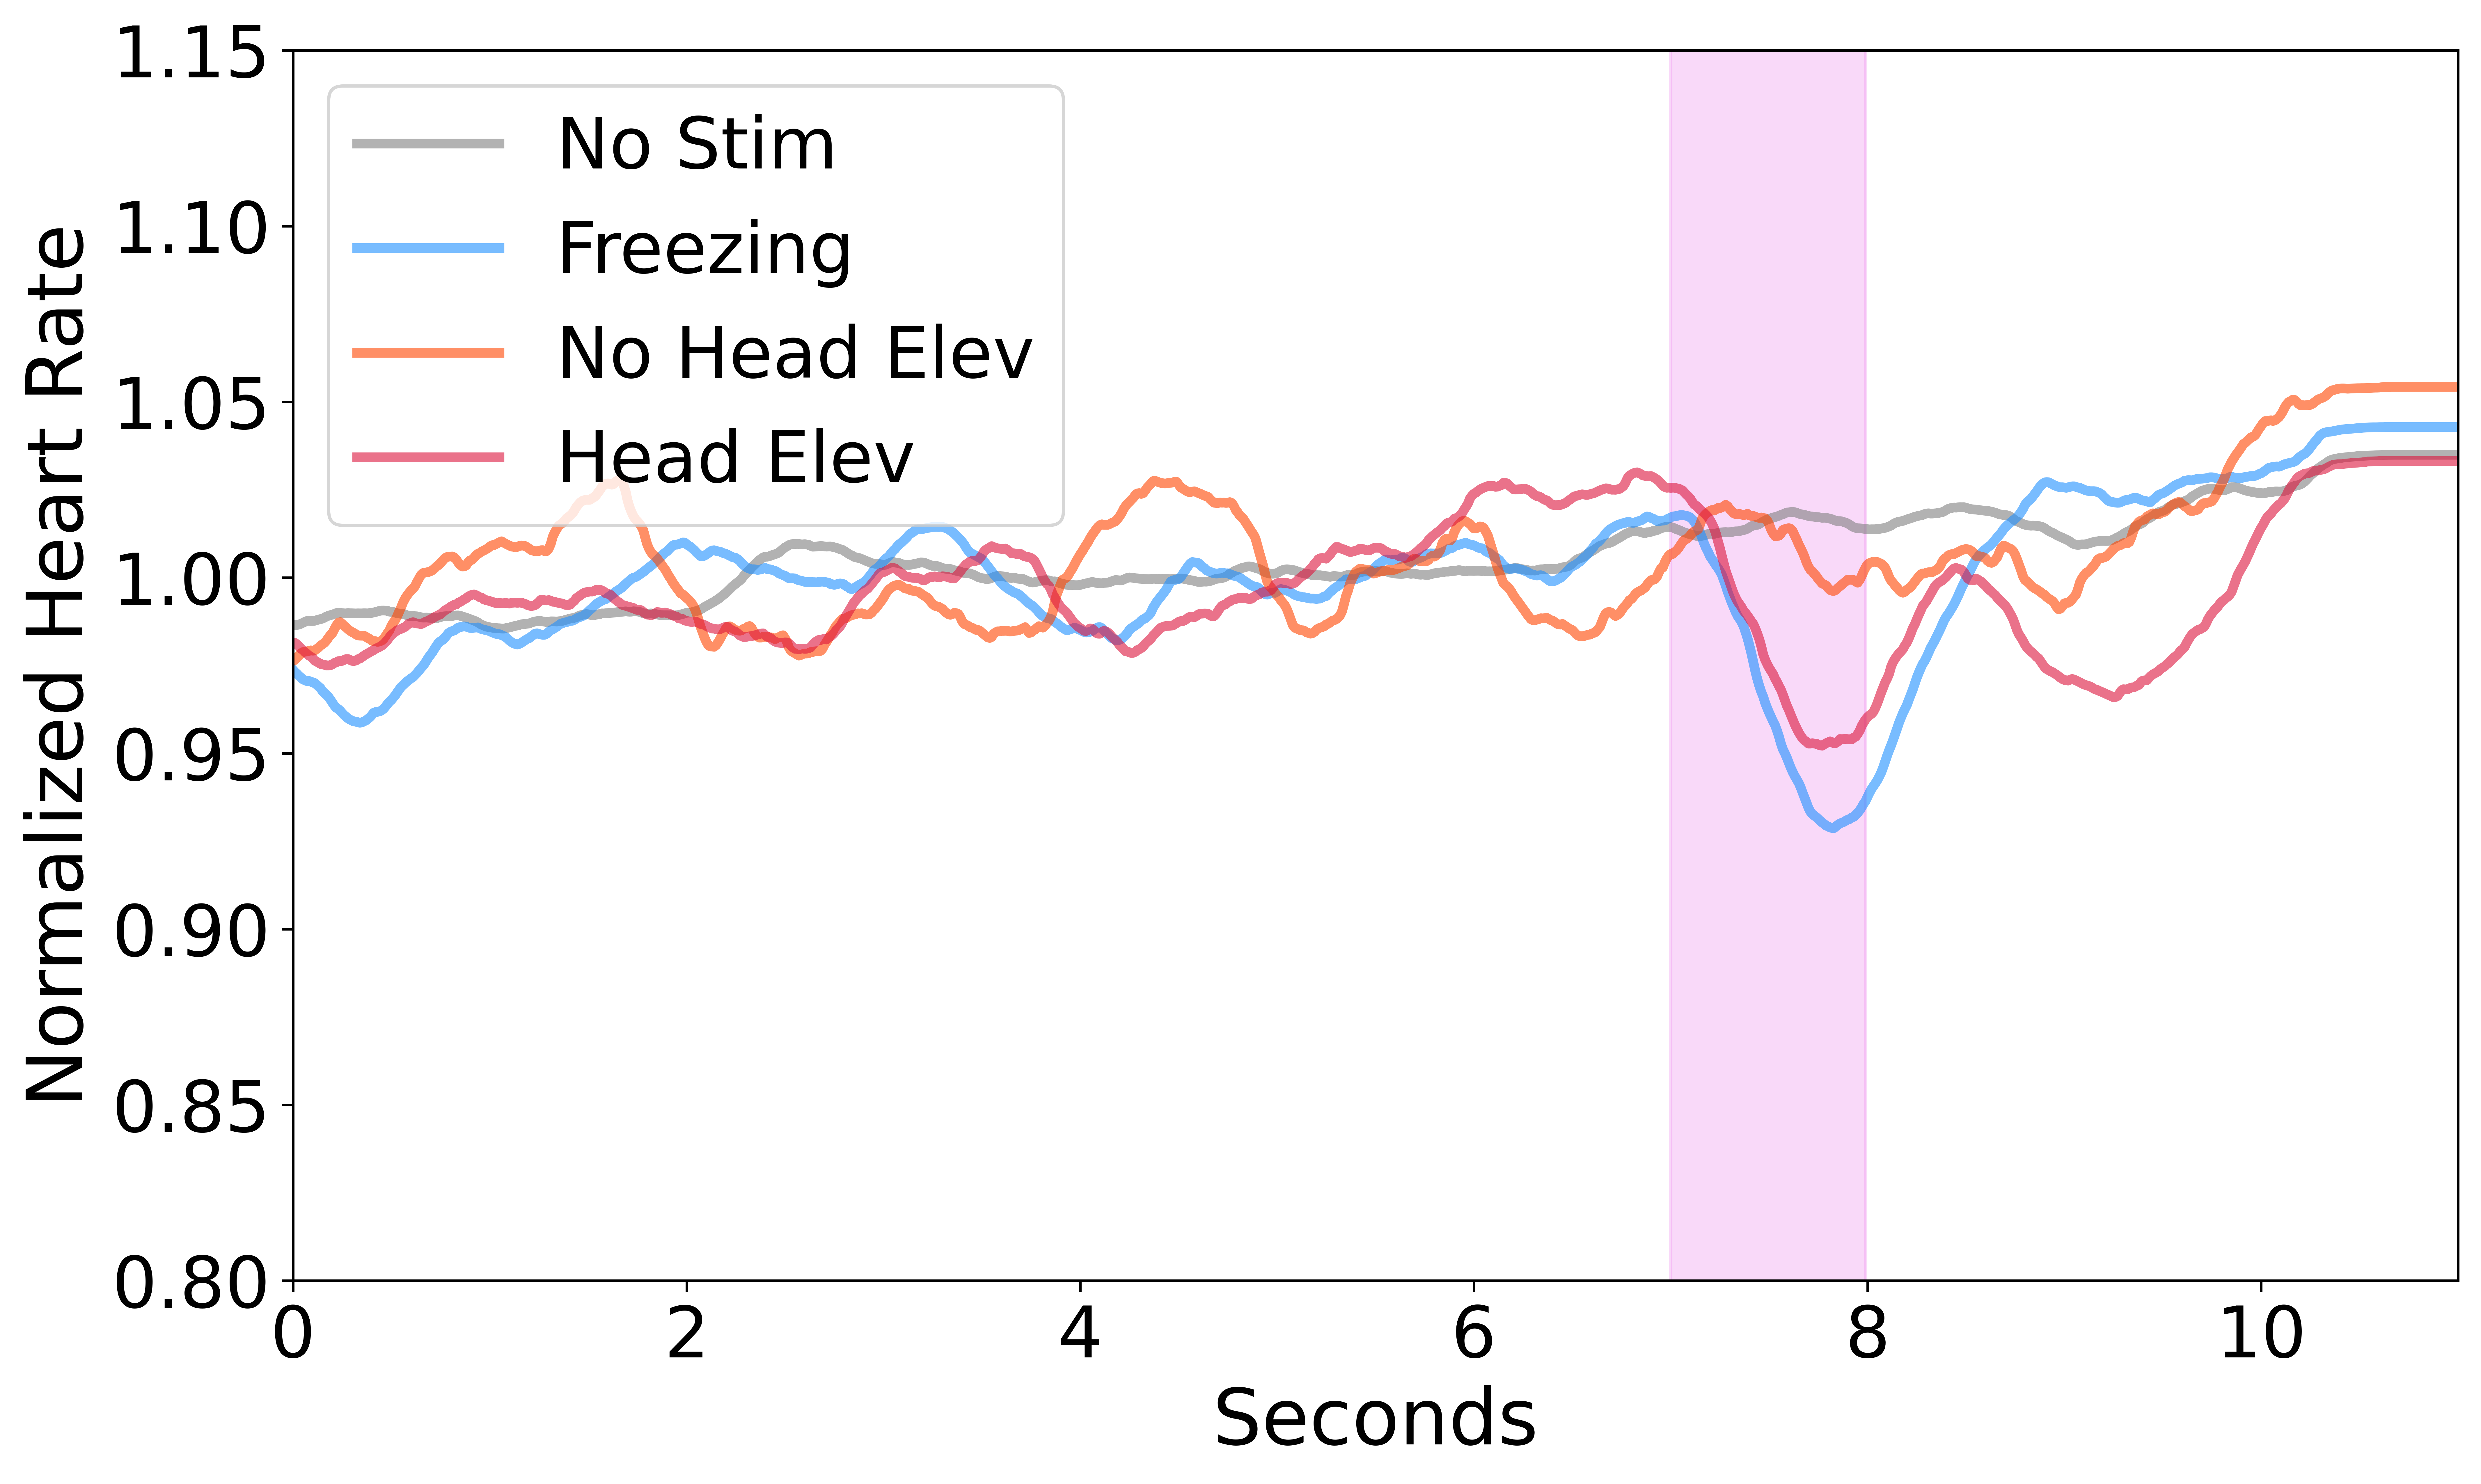

In [46]:
# overlay
plt.figure(figsize = (12,7),dpi = 800)
#fig.suptitle('Heart Rate of ' + heart_list[f][-25:-17])
# fig.suptitle('Fish Heart Rate of different stimulus')
x = np.arange(1100)/100
color_list = ['grey','dodgerblue','orangered','crimson']
# ax_list= [ax1,ax2,ax3,ax4,ax5,ax6]

for c,color in zip(stimulus_list,color_list):

    avg = []
    std = []
    std_plus = []
    std_minus = []
    for t in range(200,len(locals()['Trace_' + c][0])):
        frame_hr = []
        for l in range(0,len(locals()['Trace_' + c])):
            frame_hr.append(locals()['Trace_' + c][l][t])
        avg.append(np.mean(frame_hr))
        std.append(np.std(frame_hr))
        std_plus.append(np.mean(frame_hr)+ np.std(frame_hr))
        std_minus.append(np.mean(frame_hr) - np.std(frame_hr))
    plt.plot(x,avg,linewidth = 3,c = color,alpha = 0.6)
x1 = np.arange(700,800)/100
plt.fill_between(x1,2,-2,linewidth = 1,color = 'violet',alpha = 0.3)
plt.legend(['No Stim','Freezing','No Head Elev','Head Elev'],fontsize=22,loc = 'upper left')
plt.ylim(0.80,1.15)
plt.yticks(fontsize = 22)
plt.xticks(fontsize = 22)
plt.xlim(0,11)
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel("Normalized Heart Rate",fontsize = 24)
plt.xlabel("Seconds",fontsize = 24)

plt.show()

No_Stimulus and Freezing: 0.003069600101707584
No_Stimulus and Prey: 0.10136500036958196
No_Stimulus and Strike: 0.0023547317685473188
Freezing and Prey: 0.4099184989854595
Freezing and Strike: 0.7680689611825081
Prey and Strike: 0.2805226824853799


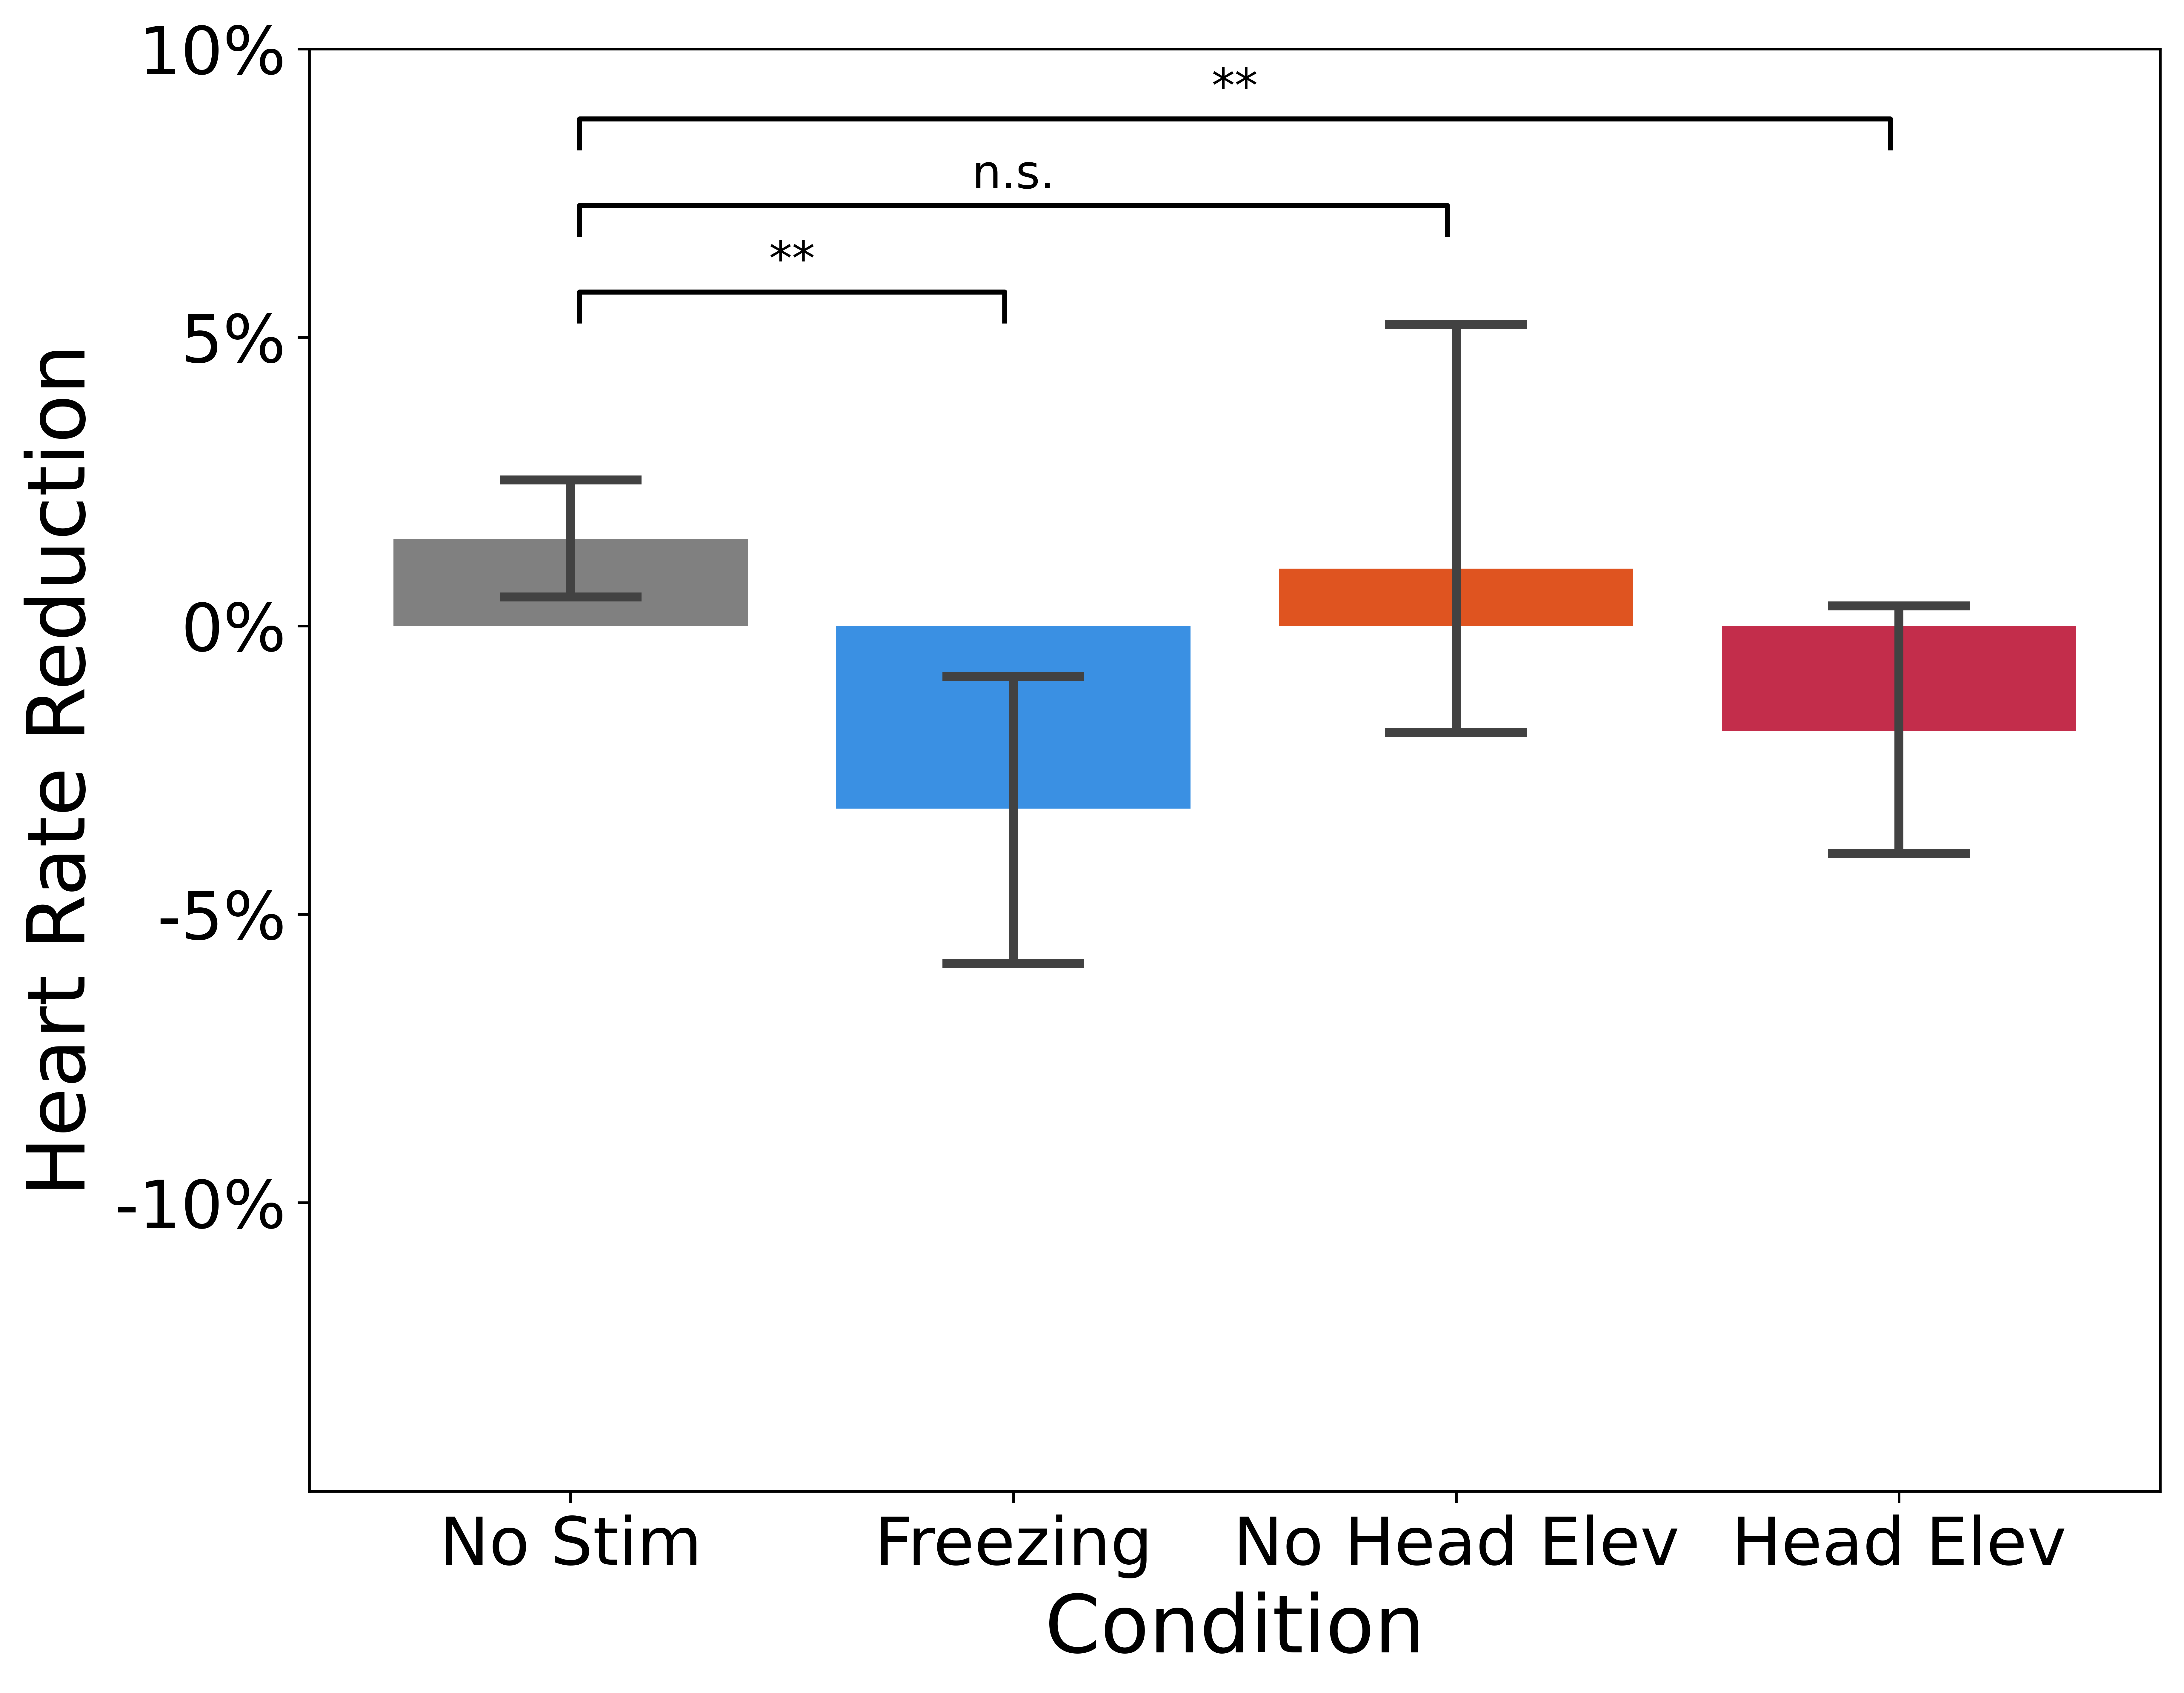

In [47]:
#5.3 Heart Rate Reduction of each condition
from scipy import integrate
df_avg_heart_rate = pd.DataFrame(columns = ['avg_value','min_value','category'])

for c in stimulus_list:
    locals()['brady' + c] = 0

for c in stimulus_list:
    for i in range(0,len(locals()['Trace_' + c])):
        df_value_no = df_avg_heart_rate.shape[0]
        df_avg_heart_rate.loc[df_value_no,'avg_value'] = -1+np.mean(locals()['Trace_' + c][i][900:1000])
        if df_avg_heart_rate.loc[df_value_no,'avg_value'] <= -0.04:
            locals()['brady' + c] += 1    
        df_avg_heart_rate.loc[df_value_no,'min_value'] = np.min(locals()['Trace_' + c][i][900:1000])
        df_avg_heart_rate.loc[df_value_no,'category'] = c
    
df_avg_heart_rate['avg_value'] = df_avg_heart_rate['avg_value'].astype(float)
df_avg_heart_rate['min_value'] = df_avg_heart_rate['min_value'].astype(float)
import seaborn as sns
import scipy
for c in stimulus_list:
    locals()['np_HR_'+c] = np.array(df_avg_heart_rate[df_avg_heart_rate['category'] == c]['avg_value']).astype(float)
# condition_list = ['m','lum','s','ns']
for i in range(0,len(stimulus_list)-1):
    con_i = stimulus_list[i]
    for j in range(i+1,len(stimulus_list)):
        con_j = stimulus_list[j]
        locals()['sig_'+str(con_i)+'_'+str(con_j)] = scipy.stats.mannwhitneyu(locals()['np_HR_'+str(con_i)], locals()['np_HR_'+str(con_j)], use_continuity=True, alternative='two-sided')[1]
        print(str(con_i)+' and '+str(con_j)+': '+str(locals()['sig_'+str(con_i)+'_'+str(con_j)]))
        
comparasion_pairs=[(0,1),(0,2),(0,3)] 
heights = [0.05,0.065,0.08]
def stars(p):
    if p < 0.0001:
        return "****"
    elif (p < 0.001):
        return "***"
    elif (p < 0.01):
        return "**"
    elif (p < 0.05):
        return "*"
    else:
        return "n.s."
plt.figure(figsize = (10,8),dpi = 800)
ax = sns.barplot(x="category", y="avg_value", data=df_avg_heart_rate,capsize=.3,palette = color_list)
ax.set_xticklabels(['No Stim','Freezing','No Head Elev','Head Elev'],fontsize = 24)

ax.set_ylim((-0.15,0.10))

ax.set_ylabel('Heart Rate Reduction',fontsize = 24)
ax.set_xlabel('Condition',fontsize = 24)
plt.yticks([-0.1,-0.05,0.0,0.05,0.10],['-10%','-5%','0%','5%','10%'],fontsize =20)
plt.xticks(fontsize =20)


for i in range(0,len(comparasion_pairs)) :
    x_1, x_2 = comparasion_pairs[i][0],comparasion_pairs[i][1]
    con_i, con_j = stimulus_list[x_1], stimulus_list[x_2]
    sig_value = locals()['sig_'+str(con_i)+'_'+str(con_j)]
    
    y, h = np.array(df_avg_heart_rate['avg_value']).mean()+heights[i],0.005
    ax.plot([x_1+0.02, x_1+0.02, x_2-0.02, x_2-0.02], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x_1+x_2)*.5, y+h*1.25, stars(sig_value) , size = 14,ha='center', va='bottom', color='black')


plt.show()